# DeepAR with validation loss, 20 epochs

In this notebook we identify the best/worst preforming seeds when we run DeepAR with validation data. Then we look at the validation loss to see if we can spot bad seeds during training.

### Load metrics so we can find the best and worst seeds

In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
from tensorboard.backend.event_processing import event_accumulator

from src.metrics import *

In [2]:
experiment_path = "/home/dev/deepts/experiments/deep_ar/electricity/6B"
exp = load_data(experiment_path)

len(exp)

100

In [3]:
exp[0].head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
index,,,,,,,,,,,,,,,,,
0,0.0,116.926534,217.059235,264.0,11.000000,8.026991,1.126715,2.198519,0.754064,NaN,25.207971,179.092984,0.833333,217.059237,0.875000,96.620364,0.916667
1,1.0,16.148134,73.656425,2351.0,97.958333,9.571517,0.320641,0.030799,0.031036,NaN,2.230384,48.552785,0.000000,73.656425,0.500000,50.017419,0.958333
2,2.0,0.562752,12.949927,192.0,8.000000,8.663515,0.062282,0.063176,0.066687,NaN,0.617710,7.837137,0.000000,12.949928,0.041667,6.846286,0.916667
3,3.0,1273.065104,632.543091,10260.0,427.500000,48.394032,0.544612,0.059212,0.061106,NaN,6.346063,238.407465,0.041667,632.543121,0.416667,379.089740,0.750000
4,4.0,880.177246,581.003967,4347.0,181.125000,25.376830,0.953961,0.131667,0.144137,NaN,18.209939,198.760747,0.041667,581.003967,0.083333,469.020071,0.375000


In [4]:
metric = ["MAPE"]

In [5]:
exp_array = calculate_timeseries_means(exp, metric, 321)
exp_array.shape

(100, 321, 1)

In [6]:
exp[0].head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
index,,,,,,,,,,,,,,,,,
0,0.0,116.926534,217.059235,264.0,11.000000,8.026991,1.126715,2.198519,0.754064,NaN,25.207971,179.092984,0.833333,217.059237,0.875000,96.620364,0.916667
321,0.0,196.036153,281.069519,284.0,11.833333,8.025109,1.459323,1.903808,0.774655,NaN,35.817873,262.503781,0.833333,281.069515,0.916667,115.311700,0.958333
642,0.0,180.016174,281.607666,189.0,7.875000,8.024132,1.462296,2.847444,0.949378,NaN,45.490816,390.565596,0.875000,281.607681,0.958333,69.109248,0.958333
963,0.0,15.546420,67.495903,166.0,6.916667,8.019890,0.350669,0.710065,0.449225,NaN,9.619020,44.006901,0.375000,67.495904,0.458333,56.138852,0.666667
1284,0.0,10.966482,57.779583,154.0,6.416667,8.016509,0.300316,0.490912,0.534464,NaN,7.485128,22.466103,0.083333,57.779582,0.208333,59.471167,0.541667
1605,0.0,30.929710,67.325592,207.0,8.625000,8.010442,0.350197,0.559697,0.338408,NaN,6.565033,36.130734,0.291667,67.325590,0.500000,44.238890,0.875000
1,1.0,16.148134,73.656425,2351.0,97.958333,9.571517,0.320641,0.030799,0.031036,NaN,2.230384,48.552785,0.000000,73.656425,0.500000,50.017419,0.958333
322,1.0,55.433812,139.309204,2427.0,101.125000,9.567923,0.606668,0.057562,0.060106,NaN,5.397389,72.375907,0.000000,139.309204,0.083333,59.299098,0.833333
643,1.0,139.768880,212.830399,2526.0,105.250000,9.561208,0.927491,0.081473,0.086503,NaN,11.845060,89.962611,0.000000,212.830399,0.125000,117.460559,0.666667


### The top 10 best and worst scoring seeds

In [7]:
n = 10

(array([  1.,  22., 117.,   3.,  56.,   1.,   1.,   0.,  14., 251.,   7.,
          4.,   3.,   0.,  36.,   2.,   2.,   1., 290.,   2., 184.,  30.,
         26.,   1.,   0.,   0.,   3.,   4.,   1., 167.,   4.,   4.,  94.,
          8.,   0., 282.,   1., 292.,   2.,  20.,   1.,   1.,   2.,   0.,
         14., 126., 213.,   2.,  50.,   1.,   0.,   1.,   2.,   2.,   1.,
         11.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   9.,   3., 169.,
          1.,   2.,   1.,   1.,   2.,  14.,   0.,   1.,   4.,  40.,   3.,
          1.,   0.,   1.,   1.,   4.,   2.,  11.,   0.,   0.,   2., 158.,
         41.,   2.,  57.,  12.,   2.,   1.,   0., 104.,   0.,   4.,   0.,
        191.]),
 array([37, 18, 35,  9, 46, 99, 20, 65, 29, 87]),
 array([292., 290., 282., 251., 213., 191., 184., 169., 167., 158.]))

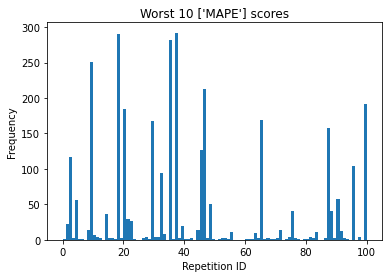

In [8]:
indexes_worst10, worst10 = np.unique(np.argsort(exp_array, axis=0)[-n:], return_counts=True)
worst_10_count = count_repetitions_among_top_n(indexes_worst10, worst10, 100)
plt.title(f"Worst {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(100)], bins=100, range=(0, 100), weights=worst_10_count)

worst_10_count, np.argsort(worst_10_count)[-n:][::-1], worst_10_count[np.argsort(worst_10_count)[-n:][::-1]]

(array([  8.,   8.,   5.,  21.,   7.,  70., 100.,  51.,  13.,   5., 122.,
         77.,  77.,  23.,   7.,  35.,  95.,  17.,   6.,   6.,   5.,   6.,
          5.,  12.,  11.,  85.,   2.,  34.,  59.,   8.,  50.,  11.,  14.,
         57.,  16.,   3.,  39.,   5.,  52.,   8.,  59.,   6.,  57., 123.,
          7.,   8.,   3.,   7.,   4.,  22.,  54.,  45.,  65.,   4.,  10.,
         11.,   4.,  27.,  24.,  19.,  90.,  10.,  59.,  28.,  22.,   2.,
         25.,  23.,  29.,  30.,  47.,  16.,  72.,  31.,  38.,   4.,  45.,
         57.,  37.,  54.,  83.,  54.,  16.,  20.,  27.,  22.,  57.,   3.,
          7.,  13.,   6.,   5.,  45.,  34.,  74.,   4., 152.,  52.,  16.,
          7.]),
 array([96, 43, 10,  6, 16, 60, 25, 80, 12, 11]),
 array([152., 123., 122., 100.,  95.,  90.,  85.,  83.,  77.,  77.]))

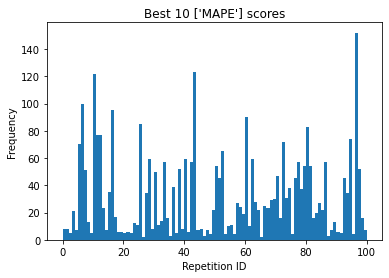

In [9]:
indexes_best10, best10 = np.unique(np.argsort(exp_array, axis=0)[:n], return_counts=True)
best_10_count = count_repetitions_among_top_n(indexes_best10, best10, 100)
plt.title(f"Best {n} {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(100)], bins=100, range=(0, 100), weights=best_10_count)

best_10_count, np.argsort(best_10_count)[-n:][::-1], best_10_count[np.argsort(best_10_count)[-n:][::-1]]

### Read log files

In [10]:
logdir = "/home/dev/deepts/logs/deep_ar/electricity"
folders = os.listdir(logdir)
date = "2020-08-24"

validation_loss = np.empty((100, 20))


for folder in folders:
    if not folder.startswith("seed") or not folder.endswith(date):
        continue

    seed_num = int(re.split("(\d+)", folder)[1])

    ea = event_accumulator.EventAccumulator(
        f"{logdir}/{folder}",
        size_guidance={event_accumulator.SCALARS: 0}
    )
    ea.Reload()
    for i in range(len(ea.Scalars("validation_loss"))):
        validation_loss[seed_num, i] = ea.Scalars("validation_loss")[i].value

validation_loss, validation_loss.shape


(array([[ 7.33529615,  7.20173264,  6.85569763, ...,  6.24090767,
          6.12933874,  6.32554436],
        [13.50861168,  6.7228179 ,  6.47709417, ...,  6.546731  ,
          6.9841795 ,  6.22366667],
        [ 7.17872715,  7.01710653,  6.47811079, ...,  6.19632006,
          6.40353489,  6.12749815],
        ...,
        [ 7.02343464,  8.21784782,  6.63644457, ...,  5.98287201,
          6.17001438,  6.03050375],
        [ 7.39551687,  7.22087479,  7.50880337, ...,  5.96858883,
          6.2194953 ,  6.60394287],
        [ 7.01063919,  7.31733751,  6.49451876, ...,  6.05900621,
          6.31935787,  5.97677803]]),
 (100, 20))

In [11]:
num_plots = 10

### Plot of the worst validation losses

Text(0.5, 1.0, 'Validation loss for worst 10 seeds')

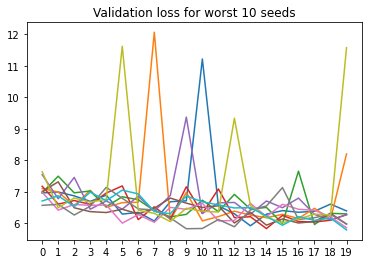

In [12]:
for seed in validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]]:
    plt.plot(seed)

plt.xticks([int(i) for i in range(validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]].shape[-1])])
plt.title(f"Validation loss for worst {num_plots} seeds")

### Plot of best validation losses

Text(0.5, 1.0, 'Validation loss for best 10 seeds')

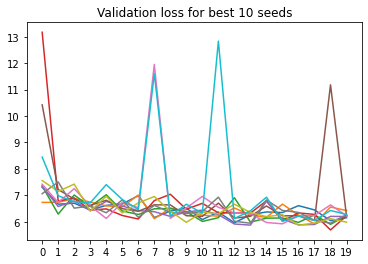

In [13]:
for seed in validation_loss[np.argsort(best_10_count)[-num_plots:][::-1]]:
    plt.plot(seed)

plt.xticks([int(i) for i in range(validation_loss[np.argsort(best_10_count)[-num_plots:][::-1]].shape[-1])])
plt.title(f"Validation loss for best {num_plots} seeds")

### Mean of best validation losses and mean of worst validation losses

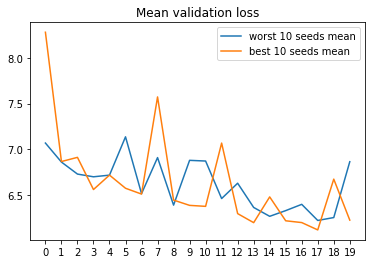

In [14]:
worst_val_loss = validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]]
best_val_loss = validation_loss[np.argsort(best_10_count)[-num_plots:][::-1]]

plt.xticks([int(i) for i in range(validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]].shape[-1])])
plt.plot(worst_val_loss.mean(axis=0), label=f"worst {num_plots} seeds mean")
plt.plot(best_val_loss.mean(axis=0), label=f"best {num_plots} seeds mean")
plt.title("Mean validation loss")
plt.legend()

### Increasing the number of plots to 20

In [15]:
num_plots = 20

Text(0.5, 1.0, 'Validation loss for worst 20 seeds')

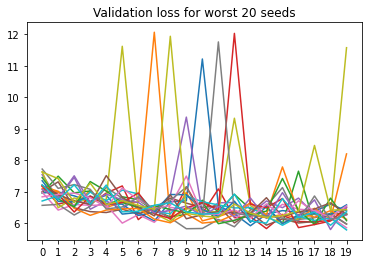

In [16]:
for seed in validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]]:
    plt.plot(seed)

plt.xticks([int(i) for i in range(validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]].shape[-1])])
plt.title(f"Validation loss for worst {num_plots} seeds")

Text(0.5, 1.0, 'Validation loss for best 20 seeds')

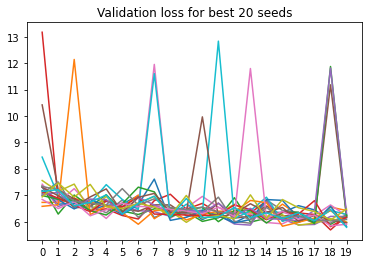

In [17]:
for seed in validation_loss[np.argsort(best_10_count)[-num_plots:][::-1]]:
    plt.plot(seed)

plt.xticks([int(i) for i in range(validation_loss[np.argsort(best_10_count)[-num_plots:][::-1]].shape[-1])])
plt.title(f"Validation loss for best {num_plots} seeds")

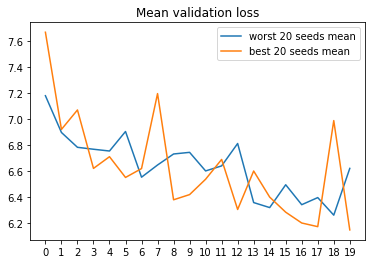

In [18]:
worst_val_loss = validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]]
best_val_loss = validation_loss[np.argsort(best_10_count)[-num_plots:][::-1]]

plt.plot(worst_val_loss.mean(axis=0), label=f"worst {num_plots} seeds mean")
plt.plot(best_val_loss.mean(axis=0), label=f"best {num_plots} seeds mean")

plt.xticks([int(i) for i in range(validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]].shape[-1])])
plt.title("Mean validation loss")
plt.legend()

So there seems to be no obvious pattern when looking at the validation loss for good and bad seeds. The graphs of the mean validation loss crosses at several places, and at the final epoch the best performing seeds are the lowest ones in terms of loss. Could it be that stopping the training one epoch earlier will produce completly different results in terms of good and bad performing seeds?

### Does the two means approach eachother when we increase the number seeds we look at?

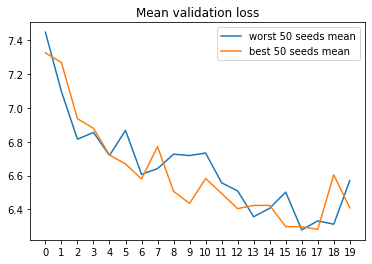

In [19]:
num_plots = 50

worst_val_loss = validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]]
best_val_loss = validation_loss[np.argsort(best_10_count)[-num_plots:][::-1]]

plt.plot(worst_val_loss.mean(axis=0), label=f"worst {num_plots} seeds mean")
plt.plot(best_val_loss.mean(axis=0), label=f"best {num_plots} seeds mean")

plt.xticks([int(i) for i in range(validation_loss[np.argsort(worst_10_count)[-num_plots:][::-1]].shape[-1])])
plt.title("Mean validation loss")
plt.legend()

Looking at these plots it seems like the validation loss is not very stable, and does not seperate between good and bad seeds that well. It does look like the network hasn't fully converged yet, so we should try to run this with more epochs.

Could it be that the validation loss (loss function is the negative likelihood) does not really reflect how well a seed scores on a metric like MAPE?